In [1]:
import sys,os
os.chdir('../../')
sys.path.append('./src/data')
sys.path.append('./src/events')
sys.path.append('./src/probability')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from DC.importer import *
from DC.processer import *
from DC.main import get_all_events,get_events
from functions import perform_chisq, dc_params_nsi, dc_params
from DC.event_processing import list_of_params_nsi, return_precomputed_nsi, get_deltachi, to_hist
from scipy.stats import chi2
import pickle
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
np.set_printoptions(linewidth=200)
Ebins_2018_midpoints = Ebins_2018[0:-1] +np.diff(Ebins_2018)/2

In [2]:
ndim = 3
pid = 1
livetime = 2.45*365*24*3600 #Effective livetime table1 DC2019
precomputed_events = True
dc_params_nsi['dm_41'] = 0.93
dc_params['dm_41'] = 0.93
emm_range = np.linspace(0,0,1)
s24_range = np.linspace(0,0,1)
emt_range = np.linspace(-1e-2,1e-2,10)
param_list = list_of_params_nsi(dc_params_nsi,s24_range, emm_range,emt_range)

#for p in param_list: # Assert all dicts returned from param_list have precomputed probs.
#    assert is_precomputed_nsi(N=N,ndim=ndim, dict=p,check=False)



param_list = return_precomputed_nsi(pid,ndim,params=param_list)
emm_range = np.sort(np.unique(np.array([p['e_mm'] for p in param_list])))
s24_range = np.sin(2*np.sort(np.unique(np.array([p['theta_24'] for p in param_list]))))**2
emt_range = np.sort(np.unique(np.array([p['e_mt'] for p in param_list])))

print(emm_range)
print(s24_range)
print(emt_range)

#print(param_list[1])

[0.]
[0.]
[-0.01       -0.00777778 -0.00555556 -0.00333333 -0.00111111  0.00111111  0.00333333  0.00555556  0.00777778  0.01      ]


In [3]:
if not precomputed_events:
    print('Computing events')
    from multiprocessing import Pool
    data_H1 = [(p, pid,True) for p in param_list]
    data_H0 = [(Ebin,zbin,param_list[0],pid,False,False) for Ebin in range(8) for zbin in range(8)]
    p = Pool()
    H1_events_list = p.starmap(get_all_events, data_H1)
    H0_events = p.starmap(get_events, data_H0)
    p.close()
    H0_events = np.array(H0_events).reshape(8,8)
    pickle.dump(H1_events_list,open(f'./pre_computed/H1_DC_{pid}_{len(emm_range)}x{len(emt_range)}_tau_nsi.p','wb'))
    pickle.dump(H0_events,open(f'./pre_computed/H0_DC_{pid}.p','wb'))


H1_list = [pickle.load(open(f'./pre_computed/H1_DC_{pid}_{len(emm_range)}x{len(emt_range)}_tau_nsi.p','rb')) for pid in [0,1]]
H0_list = [pickle.load(open(f'./pre_computed/H0_DC_{pid}.p','rb')) for pid in [0,1]]

H1 = np.array(H1_list)*livetime
H0 = np.array(H0_list)*livetime
H1 = np.swapaxes(H1,0,1)

#no_osc = np.array([get_all_events(params=param_list[0], pid=0, nsi=True, no_osc=True),get_all_events(params=param_list[0], pid=1, nsi=True, no_osc=True)])

In [4]:
no_osc_paper = np.array([no_osc2018_DC(0)[1].values,no_osc2018_DC(1)[1].values])
H0_paper = np.array([pd.read_csv('./src/data/files/DC/2018/cascade_H0.csv', header=None)[1].values,pd.read_csv('./src/data/files/DC/2018/track_H0.csv', header=None)[1].values])
events = np.array([get_hist(events2018_DC().query(f'pid==0'), 'count_events'),get_hist(events2018_DC().query(f'pid==1'), 'count_events')])
background = np.array([get_hist(events2018_DC().query(f'pid==0'), 'count_background'), get_hist(events2018_DC().query(f'pid==1'), 'count_background')])

In [5]:
best_fit_contamination = 0.055/(np.sum(background,axis=(1,2))/np.sum(events,axis=(1,2))) #table 1 DC2017

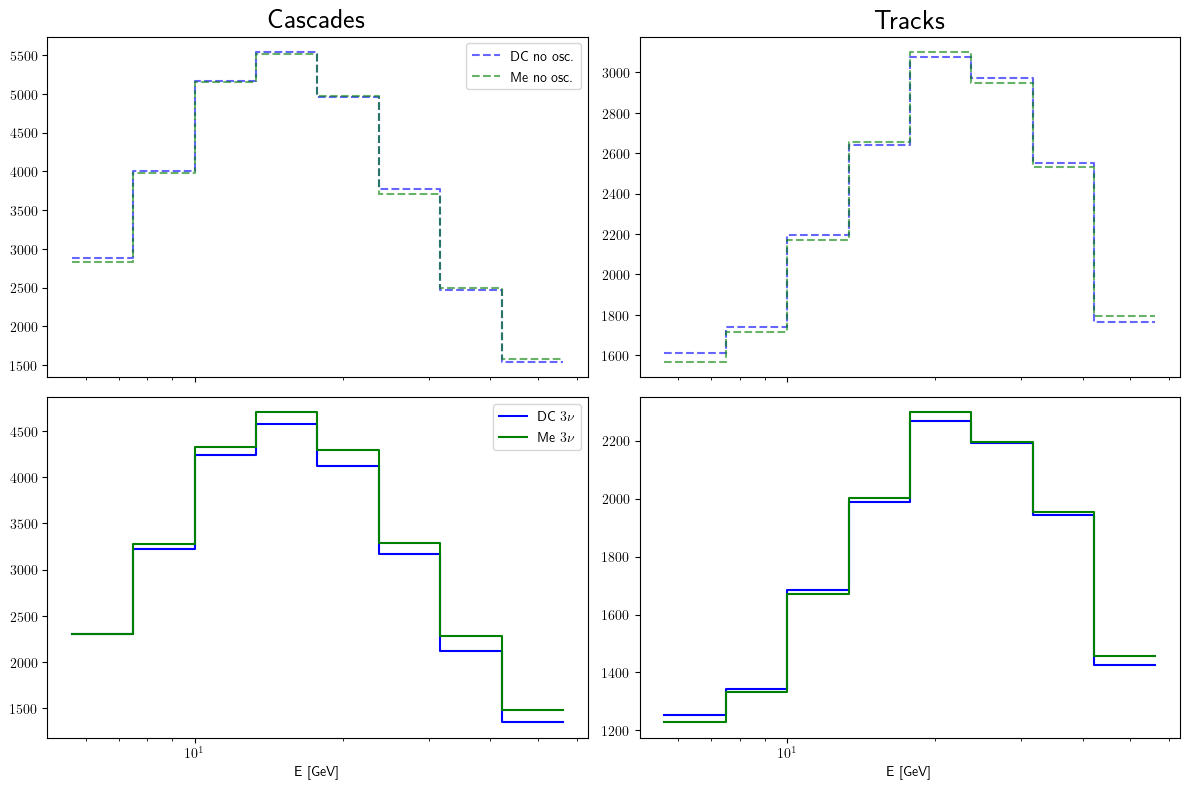

In [15]:
fig, ax = plt.subplots(2,2, figsize=(12,8), sharex=True)
norm_factor = np.array([0.9,0.9])
back_factor = np.array([0.15,1])
for pid in [0,1]:
    ax[0,pid].step(Ebins_2018, to_hist(no_osc_paper[pid]), color = 'blue', ls = '--', alpha = 0.6, label='DC no osc.', where='post')
    ax[0,pid].step(Ebins_2018, to_hist(norm_factor[pid]*np.sum(no_osc[pid],axis=1)*livetime + back_factor[pid]*np.sum(background[pid],axis=1)), color = 'green', ls='--', alpha=0.6, label='Me no osc.', where='post')
    ax[0,pid].set_xscale('log')
    ax[1,pid].step(Ebins_2018, to_hist(H0_paper[pid]), color = 'blue', label=r'DC $3\nu$', where='post')
    ax[1,pid].step(Ebins_2018, to_hist(norm_factor[pid]*np.sum(H0[pid],axis=1)), color = 'green', label=r'Me $3\nu$', where='post')
    ax[1,pid].set_xscale('log')

ax[0,0].set_title('Cascades',fontsize=20)
ax[0,1].set_title('Tracks',fontsize=20)
ax[1,0].set_xlabel('E [GeV]')
ax[1,1].set_xlabel('E [GeV]')
ax[0,0].legend()
ax[1,0].legend()
fig.tight_layout()

In [16]:
data = np.sum(events,axis=2)

H0_factors = H0_paper / np.sum(H0,axis=2)
noosc_factors = (no_osc_paper - back_factor.reshape(-1,1)*np.sum(background,axis=2)) / (np.sum(no_osc,axis=2)*livetime) #can laos use best_fit_contamination here

# Normalize NSI hypothesis
H1_nonorm = H1 #No normalization
H1_norm_H0 = H1 * H0_factors[None,:,None,:] #Norm against H0
H1_norm_noosc = H1*noosc_factors[None,:,None,:] # Norm against no oscillation

In [17]:
'''
H0_per_interaction = np.sum(np.array(H0_events),axis=(0,3))*livetime
H0_per_interaction[[0,1],:] = H0_per_interaction[[1,0],:]
labels=['m','e','t','nc']
plt.stackplot(Ebins_2018_midpoints, H0_per_interaction, labels=labels)
plt.xscale('log')
plt.legend()
'''

"\nH0_per_interaction = np.sum(np.array(H0_events),axis=(0,3))*livetime\nH0_per_interaction[[0,1],:] = H0_per_interaction[[1,0],:]\nlabels=['m','e','t','nc']\nplt.stackplot(Ebins_2018_midpoints, H0_per_interaction, labels=labels)\nplt.xscale('log')\nplt.legend()\n"

In [21]:
H1_norm_H0[0]

array([[[273.56469341, 393.71845116, 475.72477364, 449.1927482 , 338.86537946, 199.0809718 ,  87.6034    ,  25.62693828],
        [343.86746119, 477.0263338 , 595.50213278, 606.55416315, 512.81152096, 359.40893442, 205.79985035,  85.10176105],
        [407.97497525, 548.56252538, 676.30180404, 723.78987939, 683.79855171, 553.4179927 , 378.94048484, 204.62468435],
        [402.76268294, 524.98073063, 661.84895554, 745.81797057, 734.35434805, 646.52155696, 480.45519216, 330.25653714],
        [348.86724978, 449.90351614, 570.02196386, 659.45914319, 673.15807842, 603.9728227 , 478.4918803 , 349.76730263],
        [256.01928474, 329.61501026, 424.85015279, 511.58618019, 532.47218713, 474.67914545, 360.61056119, 277.18007954],
        [180.25317105, 229.48055961, 301.75344902, 366.13259573, 379.92588453, 319.53442172, 240.28019934, 182.15304758],
        [123.61815694, 154.02688157, 196.44293141, 249.65671478, 248.69531074, 210.63100166, 146.14722255, 103.51800431]],

       [[184.19130682,

In [4]:
sigma_a = 0.25
sigma_b = 0.04
f = 0
deltachi,  best_fit_index, _ = get_deltachi([H for H in H1],emt_range,emm_range,0,[sigma_a,sigma_b],f,x0=[1,1])
#s24_cl90, s24_cl99, emm_cl90, emm_cl99 = get_contour(deltachi.T, emt_range,emm_range,2)
#best_fit_coords = (param_list[best_index]['e_mt'], param_list[best_index]['e_mm'])

ValueError: setting an array element with a sequence.

In [ ]:
#salvado = (-6e-3, 5.4e-3)
dc_2017 = (-6.7e-3, 8.1e-3)
demidov = (-0.023, 0.016)
plt.plot(emt_range, deltachi,label='My work')
#plt.plot(emt_range, deltachi1,label='My work, no sigma')
plt.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
#plt.axhline(chi2.ppf(0.99,1), alpha=0.3, c='black', ls = '--')
plt.axvline(demidov[0], alpha=0.6,c='green', label='Demidov 2020')
plt.axvline(demidov[1], alpha=0.6,c='green')

#plt.axvline(salvado[0], alpha=0.6,c='green', label='Salvado (90 \% CI)')
plt.axvline(dc_2017[0], alpha=0.6,c='red', label='DC 2017')
plt.axvline(dc_2017[1], alpha=0.6,c='red')
#plt.axvline(salvado[1], alpha=0.6,c='green')

#plt.text(0.0085,chi2.ppf(q = 0.90,df=1)+0.2,'90\% CL',rotation=0,fontsize=10,alpha = 0.5)
#plt.text(-0.0107,chi2.ppf(q = 0.99,df=1)+0.2,'99\% CL',rotation=0,fontsize=10,alpha = 0.5)
plt.ylim(bottom=0)
#plt.xlim((emt_range.min(), emt_range.max()))
plt.xlabel(r'$\varepsilon_{\mu\tau}$', fontsize=10)
plt.ylabel(r'$\Delta \chi^2$', fontsize=10)
plt.legend()